## Boolean Formulae dataset

This dataset consists of Boolan expressions according to the following regular tree grammar.

```
S -> and(S, S)
S -> or(S, S)
S -> not(S)
S -> x()
S -> y()
```

We sample only expressions with at most 3 binary operators (and or or). Thus, the overall set of possible trees is just above $10,000$.

In [1]:
dataset_name = 'boolean'

# set up grammar
import tesae.tree_grammar as tree_grammar
alphabet = {'and' : 2, 'or' : 2, 'not' : 1, 'x' : 0, 'y' : 0}
nonts = ['S']
start = 'S'
rules = { 'S' : [('and', ['S', 'S']), ('or', ['S', 'S']), ('not', ['S']), ('x', []), ('y', [])]}
grammar = tree_grammar.TreeGrammar(alphabet, nonts, start, rules)

In [2]:
# set up a function to generate a tree
import numpy as np
import tesae.tree as tree
def sample_tree(max_ops = 3):
    remaining_ops = max_ops
    root = tree.Tree('$')
    stk = [root]
    while stk:
        par = stk.pop()
        if remaining_ops > 0:
            if par._label != 'not':
                r = np.random.choice(5, 1, p = [0.3, 0.3, 0.1, 0.15, 0.15])
            else:
                r = np.random.choice(5, 1, p = [0.3, 0.3, 0.0, 0.2, 0.2])
        else:
            if par._label != 'not':
                r = np.random.choice(5, 1, p = [0., 0., 0.2, 0.4, 0.4])
            else:
                r = np.random.choice(5, 1, p = [0., 0., 0., 0.5, 0.5])
        if r == 0:
            child = tree.Tree('and')
            stk.append(child)
            stk.append(child)
            remaining_ops -= 1
        elif r == 1:
            child = tree.Tree('or')
            stk.append(child)
            stk.append(child)
            remaining_ops -= 1
        elif r == 2:
            child = tree.Tree('not')
            stk.append(child)
        elif r == 3:
            child = tree.Tree('x')
        elif r == 4:
            child = tree.Tree('y')
        else:
            raise ValueError('internal error!')
        par._children.append(child)
    return root._children[0].to_list_format()

def evaluate(nodes, adj):
    # counts the number of fulfilled 'and's in the
    # given tree if x = True and y = False,
    # but returns a number > 0 only if the entire
    # formula is fulfilled 
    val, count = evaluate_rec(nodes, adj, 0)
    if val:
        return count
    else:
        return 0
def evaluate_rec(nodes, adj, i):
    # evaluate the children first
    child_vals = []
    child_sum  = 0
    for j in adj[i]:
        val_j, count_j = evaluate_rec(nodes, adj, j)
        child_vals.append(val_j)
        child_sum += count_j
    if nodes[i] == 'and':
        if child_vals[0] and child_vals[1]:
            child_sum += 1
        return child_vals[0] and child_vals[1], child_sum
    if nodes[i] == 'or':
        return child_vals[0] or child_vals[1], child_sum
    if nodes[i] == 'not':
        return not child_vals[0], child_sum
    if nodes[i] == 'x':
        return True, 0
    if nodes[i] == 'y':
        return False, 0
    raise ValueError('Unknown symbol: %s' % nodes[i] )

In [3]:
# sample trees for the experiment
m = 500
trees = []
for i in range(m):
    trees.append(sample_tree())

# print average tree size
avg_size = 0
for i in range(len(trees)):
    avg_size += len(trees[i][0])
avg_size /= len(trees)
print('average tree size: %g' % avg_size)

average tree size: 5.444


In [4]:
# set up experimental metadata
num_folds   = 20
num_neurons = 256
#sparsity    = 0.1
#radius      = 0.95
#regul       = 1E-5
#w_c         = 0.9
#w_j         = 0.3
#l           = 25
#v           = 0.1

param_ranges = {
    'sparsity' : (0.1, 0.5),
    'radius' : (0.5, 0.95),
    'w_c' : (0.5, 0.95),
    'w_j' : (0.3, 0.9),
    'v' : (0.1, 0.5)
}
param_options = {
    'regul' : [1E-7, 1E-5, 1E-3, 1E-1],
    'l' : [5, 10, 25, 50]
}
hyper_m = 100
random_trials = 50


models      = ['esae', 'stesae', 'tesae']

In [5]:
# perform hyper-parameter optimization via random search on a separate dataset
hyper_train_trees = []
hyper_test_trees  = []
for i in range(hyper_m):
    hyper_train_trees.append(sample_tree())
    hyper_test_trees.append(sample_tree())

import numpy as np

params = []
hyper_errors  = np.ones((len(models), random_trials))

import random
from experiment_utils import tree_rmse
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder

for r in range(random_trials):
    print('--- random trial %d of %d --- ' % (r+1, random_trials))
    # sample a set of parameters
    param = {}
    for param_name in param_ranges:
        lo, hi = param_ranges[param_name]
        param[param_name] = random.random() * (hi - lo) + lo
    for param_name in param_options:
        options = param_options[param_name]
        param[param_name] = random.choice(options)
    params.append(param)
    # train all models with the current parameters
    for model_idx in range(len(models)):
        print(models[model_idx])
        if models[model_idx] == 'esae':
            # echo state auto encoder
            model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
            model.fit(hyper_train_trees)
        elif models[model_idx] == 'stesae':
            # tree echo state auto encoder with shared reservoir
            W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
            model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
            model.fit_svm(hyper_train_trees)
        elif models[model_idx] == 'tesae':
            # tree echo state auto encoder
            model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
            model.fit_svm(hyper_train_trees)
        else:
            raise ValueError('unknown model: %s' % models[model_idx] )

        hyper_errors[model_idx, r] = tree_rmse(model, hyper_test_trees)

# select the best parameters for each model
opt_param = []
for model_idx in range(len(models)):
    r_opt = np.argmin(hyper_errors[model_idx, :])
    opt_param.append(params[r_opt])
    print('optimal parameters for model %s with error %g:' % (models[model_idx], hyper_errors[model_idx, r_opt]))
    print(opt_param[model_idx])

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/usr/lib64/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/lib64/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence


--- random trial 1 of 50 --- 
esae
stesae
tesae
--- random trial 2 of 50 --- 
esae
stesae
tesae
--- random trial 3 of 50 --- 
esae
stesae
tesae
--- random trial 4 of 50 --- 
esae
stesae
tesae
--- random trial 5 of 50 --- 
esae
stesae
tesae
--- random trial 6 of 50 --- 
esae
stesae
tesae
--- random trial 7 of 50 --- 
esae
stesae
tesae
--- random trial 8 of 50 --- 
esae
stesae
tesae
--- random trial 9 of 50 --- 
esae
stesae
tesae
--- random trial 10 of 50 --- 
esae
stesae
tesae
--- random trial 11 of 50 --- 
esae
stesae
tesae
--- random trial 12 of 50 --- 
esae
stesae
tesae
--- random trial 13 of 50 --- 
esae
stesae
tesae
--- random trial 14 of 50 --- 
esae
stesae
tesae
--- random trial 15 of 50 --- 
esae
stesae
tesae
--- random trial 16 of 50 --- 
esae
stesae
tesae
--- random trial 17 of 50 --- 
esae
stesae
tesae
--- random trial 18 of 50 --- 
esae
stesae
tesae
--- random trial 19 of 50 --- 
esae
stesae
tesae
--- random trial 20 of 50 --- 
esae
stesae
tesae
--- random trial 21 of 50 ---

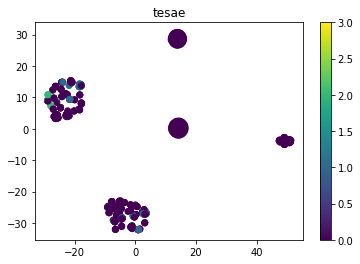

In [29]:
# reduce to two dimensions via t-SNE
from sklearn.manifold import TSNE

# set up a TES-AE model with optimal parameters
model_idx = 2
param = opt_param[model_idx]

if models[model_idx] == 'esae':
    # echo state auto encoder
    model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
    model.fit(hyper_train_trees)
elif models[model_idx] == 'stesae':
    # tree echo state auto encoder with shared reservoir
    W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
    model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
elif models[model_idx] == 'tesae':
    # tree echo state auto encoder
    model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
else:
    raise ValueError('unknown model: %s' % models[model_idx] )

# encode all trees and compute their evaluation
H = []
c = np.zeros(m)
for i in range(len(trees)):
    _, h = model.encode(*trees[i])
    H.append(h)
    c[i] = evaluate(*trees[i])
H = np.stack(H, axis=0)

H_lo = TSNE(n_components=2).fit_transform(H)

# visualize
import matplotlib.pyplot as plt
plt.scatter(H_lo[:, 0], H_lo[:, 1], c = c)
plt.colorbar()
plt.title(models[model_idx])
plt.show()
# save the low dimensional coding with evaluation
# to csv
np.savetxt('results/%s_%s_code_space.csv' % (dataset_name, models[model_idx]), np.concatenate([H_lo, np.expand_dims(c, 1)], axis=1), delimiter='\t', header='x\ty\tc', fmt='%g', comments = '')

In [30]:
# do a clustering on reduced encodings
import edist.tree_utils as tree_utils
from sklearn.cluster import KMeans

K = len(alphabet)
kmeans = KMeans(n_clusters = K)
kmeans.fit(H_lo)
# print the trees according to their cluster labels as tikz nodes
for k in range(K):
    root = trees[np.where(kmeans.labels_ == k)[0][0]][0][0]
    # check that the root is the same across all trees in the cluster
    for i in np.where(kmeans.labels_ == k)[0]:
        if trees[i][0][0] != root:
            raise ValueError('inconsistent root in cluster; expected %s but was %s' % (root, trees[i][0][0]))
    # translate symbol to latex
    if root == 'and':
        root = '\\wedge'
    elif root == 'or':
        root = '\\vee'
    elif root == 'not':
        root = '\\neg'
    print('\\node[left, outer sep=0.3cm] at (axis cs:%g,%g) {$%s$};' % (kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1], root))

\node[left, outer sep=0.3cm] at (axis cs:-2.73439,-27.2817) {$\vee$};
\node[left, outer sep=0.3cm] at (axis cs:-23.0172,9.31803) {$\wedge$};
\node[left, outer sep=0.3cm] at (axis cs:14.2131,0.225303) {$y$};
\node[left, outer sep=0.3cm] at (axis cs:13.9007,28.689) {$x$};
\node[left, outer sep=0.3cm] at (axis cs:49.4786,-3.86115) {$\neg$};


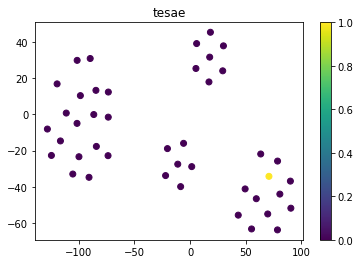

In [34]:
# visualize one of the clusters, namely all trees starting
# with 'not'
not_idxs = []
for i in range(len(trees)):
    if trees[i][0][0] == 'not':
        not_idxs.append(i)
not_idxs = np.array(not_idxs)
H_lo = TSNE(n_components=2, perplexity = 15).fit_transform(H[not_idxs, :])

# visualize
import matplotlib.pyplot as plt
plt.scatter(H_lo[:, 0], H_lo[:, 1], c = c[not_idxs])
plt.colorbar()
plt.title(models[model_idx])
plt.show()
# save the low dimensional coding with evaluation
# to csv
np.savetxt('results/%s_%s_code_space_not.csv' % (dataset_name, models[model_idx]), np.concatenate([H_lo, np.expand_dims(c[not_idxs], 1)], axis=1), delimiter='\t', header='x\ty\tc', fmt='%g', comments = '')

In [36]:
# do a clustering on reduced encodings
import edist.tree_utils as tree_utils
from sklearn.cluster import KMeans

K = 4
kmeans = KMeans(n_clusters = K)
kmeans.fit(H_lo)
# print the trees according to their cluster labels as tikz nodes
for k in range(K):
    in_cluster = not_idxs[np.where(kmeans.labels_ == k)[0]]
    root = trees[in_cluster[0]][0][1]
    # check that the root is the same across all trees in the cluster
    for i in in_cluster:
        if trees[i][0][1] != root:
            raise ValueError('inconsistent root in cluster; expected %s but was %s' % (root, trees[i][0][0]))
    # translate symbol to latex
    if root == 'and':
        root = '\\wedge'
    elif root == 'or':
        root = '\\vee'
    elif root == 'not':
        root = '\\neg'
    print('\\node[left, outer sep=0.3cm] at (axis cs:%g,%g) {$%s$};' % (kmeans.cluster_centers_[k, 0], kmeans.cluster_centers_[k, 1], root))

\node[left, outer sep=0.3cm] at (axis cs:69.1167,-44.9931) {$\wedge$};
\node[left, outer sep=0.3cm] at (axis cs:-97.7742,-3.8061) {$\vee$};
\node[left, outer sep=0.3cm] at (axis cs:17.6364,31.6872) {$x$};
\node[left, outer sep=0.3cm] at (axis cs:-10.9794,-27.4614) {$y$};


In [15]:
# perform a crossvalidation experiment
import time
import numpy as np
from sklearn.model_selection import KFold
from experiment_utils import tree_rmse
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder

# set up crossvalidation object
cv = KFold(n_splits=num_folds, shuffle=True)

# set up array for errors
errors_train = np.zeros((len(models), num_folds))
errors_test  = np.zeros((len(models), num_folds))
valid        = np.ones((len(models), num_folds))
# set up array for runtimes
runtimes = np.zeros((len(models), num_folds))
# iterate over the folds
f = -1
for train_index, test_index in cv.split(trees):
    f += 1
    print('--- fold %d of %d ---' % (f+1, num_folds))
    trees_train = []
    for i in train_index:
        trees_train.append(trees[i])
    trees_test = []
    for i in test_index:
        trees_test.append(trees[i])

    # iterate over all models
    for model_idx in range(len(models)):
        print(models[model_idx])
        param = opt_param[model_idx]
        # set up model and train it
        start = time.time()
        if models[model_idx] == 'esae':
            # echo state auto encoder
            model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
            model.fit(trees_train)
        elif models[model_idx] == 'stesae':
            # tree echo state auto encoder with shared reservoir
            W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
            model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
            model.fit_svm(trees_train)
        elif models[model_idx] == 'tesae':
            # tree echo state auto encoder
            model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
            model.fit_svm(trees_train)
        else:
            raise ValueError('unknown model: %s' % models[model_idx] )
        runtimes[model_idx, f] = time.time() - start

        errors_train[model_idx, f] = tree_rmse(model, trees_train)
        errors_test[model_idx, f]  = tree_rmse(model, trees_test)

--- fold 1 of 20 ---
esae
stesae
tesae
--- fold 2 of 20 ---
esae
stesae
tesae
--- fold 3 of 20 ---
esae
stesae
tesae
--- fold 4 of 20 ---
esae
stesae
tesae
--- fold 5 of 20 ---
esae
stesae
tesae
--- fold 6 of 20 ---
esae
stesae
tesae
--- fold 7 of 20 ---
esae
stesae
tesae
--- fold 8 of 20 ---
esae
stesae
tesae
--- fold 9 of 20 ---
esae
stesae
tesae
--- fold 10 of 20 ---
esae
stesae
tesae
--- fold 11 of 20 ---
esae
stesae
tesae
--- fold 12 of 20 ---
esae
stesae
tesae
--- fold 13 of 20 ---
esae
stesae
tesae
--- fold 14 of 20 ---
esae
stesae
tesae
--- fold 15 of 20 ---
esae
stesae
tesae
--- fold 16 of 20 ---
esae
stesae
tesae
--- fold 17 of 20 ---
esae
stesae
tesae
--- fold 18 of 20 ---
esae
stesae
tesae
--- fold 19 of 20 ---
esae
stesae
tesae
--- fold 20 of 20 ---
esae
stesae
tesae


In [16]:
# print results
for model_idx in range(len(models)):
    print(models[model_idx])
    print('Train RMSE: %g +- %g' % (np.mean(errors_train[model_idx, :]), np.std(errors_train[model_idx, :])))
    print('Test RMSE:  %g +- %g' % (np.mean(errors_test[model_idx, :]), np.std(errors_test[model_idx, :])))
    print('Runtimes:   %g +- %g' % (np.mean(runtimes[model_idx, :]), np.std(runtimes[model_idx, :])))

esae
Train RMSE: 3.06037 +- 0.0514031
Test RMSE:  3.63714 +- 0.444091
Runtimes:   1.25982 +- 0.0409216
stesae
Train RMSE: 3.10896 +- 0.0782833
Test RMSE:  3.25228 +- 0.388153
Runtimes:   2.43689 +- 0.0709219
tesae
Train RMSE: 0.435187 +- 0.0550768
Test RMSE:  2.83728 +- 0.493811
Runtimes:   3.28502 +- 0.219328


In [17]:
# write the results into a table
np.savetxt('results/%s_errors.csv' % dataset_name, errors_test.T, delimiter='\t', header='\t'.join(models), fmt='%g', comments = '')
np.savetxt('results/%s_runtimes.csv' % dataset_name, runtimes.T, delimiter='\t', header='\t'.join(models), fmt='%g', comments = '')

In [12]:
# perform CMA-ES in the coding space to find optimal trees for the current task
import tesae.crj as crj
from tesae.echo_state_auto_encoder import ESTreeWrapper
from tesae.tree_echo_state_auto_encoder import TESAutoEncoder
import cma
for model_idx in range(len(models)):
    print('\n--- %s ---' % models[model_idx])
    param = opt_param[model_idx]
    # set up model on the entire tree data set
    if models[model_idx] == 'esae':
        # echo state auto encoder
        model = ESTreeWrapper(grammar, dim = num_neurons, v = param['v'], w_c = param['w_c'], w_j = param['w_j'], l = param['l'], regul = param['regul'])
        model.fit(trees)
    elif models[model_idx] == 'stesae':
        # tree echo state auto encoder with shared reservoir
        W = crj.setup_reservoir_matrix(num_neurons, w_c = param['w_c'], w_j = param['w_j'], l = param['l']).toarray()
        model = TESAutoEncoder(grammar, dim = num_neurons, regul = param['regul'], shared_reservoir = W)
        model.fit_svm(trees)
    elif models[model_idx] == 'tesae':
        # tree echo state auto encoder
        model = TESAutoEncoder(grammar, dim = num_neurons, sparsity = param['sparsity'], radius = param['radius'], regul = param['regul'])
        model.fit_svm(trees)
    else:
        raise ValueError('unknown model: %s' % models[model_idx] )
    # encode all training trees to get a sense of the scaling
    H = []
    for i in range(len(trees)):
        _, h = model.encode(*trees[i])
        H.append(h)
    H = np.stack(H, axis=0)
    # set up objective function, starting mean, and starting standard deviation
    mu0    = np.mean(H, axis=0)
    sigma0 = np.mean(np.std(H, axis=0))
    def objective_fun(h):
        nodes, adj, *_ = model.decode(h, max_size = 15)
        try:
            return -evaluate(nodes, adj)
        except ValueError as ex:
            return 0.
    # we set the parameter so that we have the same budget as Kusner et al. (2017)
    es = cma.CMAEvolutionStrategy(mu0, sigma0, {'popsize' : 50, 'verb_disp': 1, 'maxiter' : 15})
    es.optimize(objective_fun)
    h_opt = es.result()[0]
    nodes, adj, *_ = model.decode(h_opt, max_size = 15)
    print('CMA-ES found the following optimal tree: %s with evaluation %g' % (tree_utils.tree_to_string(nodes, adj), evaluate(nodes, adj)))


--- esae ---
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 256 (seed=739847, Wed Jan 22 13:49:16 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -2.000000000000000e+00 1.0e+00 1.89e-01  2e-01  2e-01 0:0.8


/usr/lib/python3.7/site-packages/cma.py:2937: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x0 == str(x0):


    2    100 0.000000000000000e+00 1.0e+00 1.83e-01  2e-01  2e-01 0:1.9
    3    150 -1.000000000000000e+00 1.0e+00 1.78e-01  2e-01  2e-01 0:3.1
    4    200 -2.000000000000000e+00 1.0e+00 1.74e-01  2e-01  2e-01 0:4.3
    5    250 -1.000000000000000e+00 1.0e+00 1.71e-01  2e-01  2e-01 0:5.6
    6    300 -1.000000000000000e+00 1.0e+00 1.69e-01  2e-01  2e-01 0:6.7
    7    350 -1.000000000000000e+00 1.0e+00 1.67e-01  2e-01  2e-01 0:8.1
    8    400 -1.000000000000000e+00 1.0e+00 1.65e-01  2e-01  2e-01 0:9.3
    9    450 -2.000000000000000e+00 1.0e+00 1.63e-01  2e-01  2e-01 0:10.6
   10    500 -3.000000000000000e+00 1.0e+00 1.62e-01  2e-01  2e-01 0:11.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    550 -3.000000000000000e+00 1.0e+00 1.61e-01  2e-01  2e-01 0:13.3
   12    600 -5.000000000000000e+00 1.0e+00 1.60e-01  2e-01  2e-01 0:14.6
   13    650 -3.000000000000000e+00 1.0e+00 1.59e-01  2e-01  2e-01 0:15.9
   14    700 -5.000000000000000e+00 1.0e+00 1.58

In [14]:
# perform an interpolation in high dimensional space
# between a 'y' tree and an optimal point

# set up start and end point
_, start = model.encode(['y'], [[]])
end = h_opt

# perform interpolation
for alpha in np.linspace(0., 1., 11.):
    h = start * (1. - alpha) + end * alpha
    # decode
    nodes, adj, *_ = model.decode(h, max_size = 30)
    # evaluate
    print('%g: %s [%g]' % (alpha, tree_utils.tree_to_string(nodes, adj), evaluate(nodes, adj)))

0: y [0]
0.1: y [0]
0.2: and(y, and(y, x)) [0]
0.3: and(and(x, or(x, y)), and(y, x)) [0]
0.4: or(not(or(x, not(y))), and(not(and(or(y, not(y)), x)), y)) [0]
0.5: or(not(or(and(y, not(x)), not(y))), and(not(and(or(y, not(y)), x)), x)) [0]
0.6: or(not(or(and(y, not(x)), not(y))), and(not(and(or(y, not(y)), x)), x)) [0]
0.7: or(not(or(and(y, not(x)), not(y))), and(not(and(or(y, not(y)), x)), x)) [0]
0.8: or(not(or(and(y, not(x)), not(y))), and(not(and(y, x)), x)) [1]
0.9: or(not(or(y, and(and(x, x), x))), and(not(and(y, x)), x)) [3]
1: or(not(or(y, and(and(x, x), x))), and(not(and(y, x)), x)) [3]


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':
